# Impact of factors on retention

## Import libraries

In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#import geopandas as gpd

Read turnover data from csv into a dataframe.

In [170]:
#month = "february"
#year = "2023"
url = f'../01_data/processed_monthly_turnover.csv'
df = pd.read_csv(url, parse_dates=['month_year'])
#df = df.sort_values(by='Date')
df = df.drop(['n'],axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145156 entries, 0 to 145155
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   org_code     145156 non-null  object        
 1   region_name  145156 non-null  object        
 2   org_type     145156 non-null  object        
 3   staff_group  145156 non-null  object        
 4   month_year   145156 non-null  datetime64[ns]
 5   join_HC      108508 non-null  float64       
 6   join_FTE     108508 non-null  float64       
 7   leave_HC     108678 non-null  float64       
 8   leave_FTE    108678 non-null  float64       
 9   denom_HC     144909 non-null  float64       
 10  denom_FTE    144909 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 12.2+ MB


Calculate a leaver and joiner rate, drop FTE and HC columns

In [171]:
df['leaver_rate'] = df['leave_FTE']/df['denom_FTE']
df['joiner_rate'] = df['join_FTE']/df['denom_FTE']

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df['leaver_rate'].fillna(0, inplace=True)
df['joiner_rate'].fillna(0, inplace=True)

df = df.drop(['join_HC','leave_HC'],axis=1)


In [173]:
#df['staff_group'].unique()

Calculate a total staff in post (SIP; all staff) FTE column for each organisation by month.

In [174]:
# Set the 'total_sip_FTE' value to be equal to the 'FTE' value for 'All staff groups' 
allstaff_fte = df.loc[df['staff_group'] == 'All staff groups',
                      ['month_year', 'org_code', 'denom_FTE']].groupby(['month_year', 'org_code'])['denom_FTE'].sum().reset_index()

allstaff_fte.rename(columns={'denom_FTE':'total_sip_FTE'},inplace=True)


df = pd.merge(df, allstaff_fte, on=['month_year', 'org_code'], how='left')
#drop denom HC
df = df.drop(['denom_HC'],axis=1)
df.head()

The data show the full time equivalent (FTE) number of leavers by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) FTE averaged over the 12-month period to date.

Load data about local unemployment so we can use it as a regressor

In [177]:
url_r1 = '../01_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

df_r1.tail()

,Date,Region,NHSE region name,%,thousands
3343,2023-03-01,North West,North West,0.030,107
3344,2023-03-01,South East,South East,0.037,177
3345,2023-03-01,South West,South West,0.031,89
3346,2023-03-01,West Midlands,Midlands,0.048,147
3347,2023-03-01,York & the Humber,North East and Yorkshire,0.038,104


In [178]:
df_r1.drop(['Region','thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment','Date':'month_year',
                      'NHSE region name':'region_name'},inplace=True)
df_r1 = df_r1.sort_values('month_year')
df_r1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries, 0 to 3347
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   month_year          3348 non-null   datetime64[ns]
 1   region_name         3348 non-null   object        
 2   local_unemployment  3348 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 104.6+ KB


Add data about local unemployment at the regional level to the main dataframe

In [179]:
df_leaver_r1 = pd.merge(df, df_r1, on=['month_year', 'region_name'],how='left')
#df_leaver_r1 = df_leaver_r1.dropna()
df_leaver_r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166685 entries, 0 to 166684
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            166685 non-null  object        
 1   region_name         166685 non-null  object        
 2   org_type            166685 non-null  object        
 3   staff_group         166685 non-null  object        
 4   month_year          166685 non-null  datetime64[ns]
 5   join_FTE            124537 non-null  float64       
 6   leave_FTE           124682 non-null  float64       
 7   denom_FTE           166405 non-null  float64       
 8   leaver_rate         166685 non-null  float64       
 9   joiner_rate         166685 non-null  float64       
 10  total_sip_FTE       166685 non-null  float64       
 11  local_unemployment  139168 non-null  float64       
dtypes: datetime64[ns](1), float64(7), object(4)
memory usage: 15.3+ MB


In [180]:
df_leaver_r1 = df_leaver_r1.sort_values('month_year')
df_leaver_r1.tail()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,total_sip_FTE,local_unemployment
25222,RCF,North East and Yorkshire,Acute - Small,Central functions,2024-02-01,NaN,NaN,231.51455,0.0,0.0,3025.58627,NaN
103597,RTH,South East,Acute - Teaching,Midwives,2024-02-01,NaN,NaN,284.91058,0.0,0.0,11593.99306,NaN
25166,RCF,North East and Yorkshire,Acute - Small,Ambulance staff,2024-02-01,NaN,NaN,8.00000,0.0,0.0,3025.58627,NaN
104561,RTK,South East,Acute - Medium,Senior managers,2024-02-01,NaN,NaN,48.46000,0.0,0.0,3919.26900,NaN
166684,TAJ,Midlands,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",2024-02-01,NaN,NaN,871.02637,0.0,0.0,3434.33954,NaN


Load data about sickness absence to use as second regressor

In [181]:
url_r2 = '../01_data/sickness_absence.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['Date'])
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['Cluster group'].isin(trust_types_todrop)]
df_r2 = df_r2.drop(['Benchmark group','Org name',
                    'NHSE region code','Cluster group'],axis=1)
df_r2.rename(columns={'Org code':'org_code','Date':'month_year',
                      'NHSE region name':'region_name','Staff group':'staff_group'},inplace=True)
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238743 entries, 0 to 238742
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          238743 non-null  datetime64[ns]
 1   org_code            238743 non-null  object        
 2   region_name         238743 non-null  object        
 3   staff_group         238743 non-null  object        
 4   FTE days lost       238743 non-null  float64       
 5   FTE days available  238743 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 10.9+ MB


In [182]:
df_r2.tail()

,month_year,org_code,region_name,staff_group,FTE days lost,FTE days available
238738,2022-06-01,RRF,North West,Support to ST&T staff,436.00301,6546.33419
238739,2022-06-01,RVY,North West,"Hotel, property & estates",577.86664,8158.65161
238740,2022-06-01,RWE,Midlands,"Support to doctors, nurses & midwives",7081.34638,112685.24840
238741,2022-06-01,RWP,Midlands,Midwives,531.53824,6310.98954
238742,2022-06-01,RWK,London,Senior managers,38.00000,4882.41354


Add sickness absence data to the main dataframe

In [185]:
merge_cols = ['month_year', 'org_code','region_name','staff_group']
df_leaver_r2 = pd.merge(df_leaver_r1, df_r2, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
df_leaver_r2.drop_duplicates(subset=merge_cols)
df_leaver_r2.rename(columns={'FTE days lost':'fte_days_lost','FTE days available':'fte_days_available'},inplace=True)
df_leaver_r2['sickness_absence'] = df_leaver_r2['fte_days_lost']/df_leaver_r2['fte_days_available']
df_leaver_r2 = df_leaver_r2.drop(['fte_days_available'],axis=1)
df_leaver_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217802 entries, 0 to 217801
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            217802 non-null  object        
 1   region_name         217802 non-null  object        
 2   org_type            217802 non-null  object        
 3   staff_group         217802 non-null  object        
 4   month_year          217802 non-null  datetime64[ns]
 5   join_FTE            167591 non-null  float64       
 6   leave_FTE           168167 non-null  float64       
 7   denom_FTE           217498 non-null  float64       
 8   leaver_rate         217802 non-null  float64       
 9   joiner_rate         217802 non-null  float64       
 10  total_sip_FTE       217802 non-null  float64       
 11  local_unemployment  190285 non-null  float64       
 12  fte_days_lost       168130 non-null  float64       
 13  sickness_absence    167883 no

Add data about reasons for sickness absence

In [187]:
url_r3 = '../01_data/sickness_absence_reason_pivot.csv'
df_r3 = pd.read_csv(url_r3, parse_dates=['Date'])
#df_r3 = df_r3.drop(['FTE days lost'],axis=1)
df_r3.rename(columns={'Date':'month_year','Staff group':'staff_group'},inplace=True)
#df_r2 = df_r2.reset_index(drop=True)

# drop least frequent reasons for absence
df_r3 = df_r3.drop(['substance_abus','asthma',
                    'dental','blood_disorder','endocrine',
                    'eye','skin_disorders','nervous_system'],axis=1)


# Replace NaN values with 0 
df_r3 = df_r3.fillna(0)
df_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1361 entries, 0 to 1360
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   month_year         1361 non-null   datetime64[ns]
 1   staff_group        1361 non-null   object        
 2   anxiety_stress     1361 non-null   float64       
 3   back_problems      1361 non-null   float64       
 4   gastro             1361 non-null   float64       
 5   gynaecological     1361 non-null   float64       
 6   headache_mig       1361 non-null   float64       
 7   infectious_dis     1361 non-null   float64       
 8   other              1361 non-null   float64       
 9   other_msk          1361 non-null   float64       
 10  pregnancy_related  1361 non-null   float64       
 11  respiratory        1361 non-null   float64       
 12  unknown            1361 non-null   float64       
dtypes: datetime64[ns](1), float64(11), object(1)
memory usage: 138.

Add sickness absence reason data to main dataframe

In [188]:
merge_cols = ['month_year','staff_group']
df_leaver_r3 = pd.merge(df_leaver_r2, df_r3, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
#df_leaver_r3.drop_duplicates(subset=merge_cols)
df_leaver_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 217802 entries, 0 to 217801
Data columns (total 25 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            217802 non-null  object        
 1   region_name         217802 non-null  object        
 2   org_type            217802 non-null  object        
 3   staff_group         217802 non-null  object        
 4   month_year          217802 non-null  datetime64[ns]
 5   join_FTE            167591 non-null  float64       
 6   leave_FTE           168167 non-null  float64       
 7   denom_FTE           217498 non-null  float64       
 8   leaver_rate         217802 non-null  float64       
 9   joiner_rate         217802 non-null  float64       
 10  total_sip_FTE       217802 non-null  float64       
 11  local_unemployment  190285 non-null  float64       
 12  fte_days_lost       168130 non-null  float64       
 13  sickness_absence    167883 no

In [189]:
df_leaver_r3['month_year'].max()
#date_max = df['Date'].max()

Timestamp('2024-02-01 00:00:00')

Need to cut to latest date of all available data

In [190]:
max_date = '2023-02-01'
df_leaver_r3 = df_leaver_r3[df_leaver_r3['month_year'] <= max_date]

In [133]:
#url = 'REF_SICK_ABSENCE_REASONS.csv'
#df_ref_reason = pd.read_csv(url)

#reason_short = sorted(df_ref_reason['reason_short'].unique())

In [191]:
# List of columns to replace NaN values with 0
#cols = ['local_unemployment','sickness_absence','leaver_rate','joiner_rate']

# Replace NaN values with 0 in the specified columns
#df_leaver_r3[cols] = df_leaver_r3[cols].fillna(0)
#Replace all NaN with 0
df_leaver_r3 = df_leaver_r3.fillna(0)


df_leaver_r3.reset_index(drop=True)
df_leaver_r3.head()

,org_code,region_name,org_type,staff_group,month_year,join_FTE,leave_FTE,denom_FTE,leaver_rate,joiner_rate,...,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown
0,R0A,North West,Acute - Teaching,All staff groups,2019-07-01,214.415,225.3881,17710.16849,0.012726,0.012107,...,0.068083,0.106523,0.047566,0.028534,0.007154,0.096771,0.132680,0.033153,0.029796,0.061364
1,R0A,North West,Acute - Teaching,All staff groups,2019-07-01,214.415,225.3881,17710.16849,0.012726,0.012107,...,0.068083,0.106523,0.047566,0.028534,0.007154,0.096771,0.132680,0.033153,0.029796,0.061364
2,RYF,South West,Ambulance Trust,HCHS doctors (exc. junior Drs),2019-07-01,0.000,0.0000,0.40000,0.000000,0.000000,...,0.047676,0.116017,0.023949,0.025534,0.010035,0.141891,0.078136,0.030772,0.020613,0.165389
3,RJ1,London,Acute - Teaching,Support to ST&T staff,2019-07-01,8.800,9.0000,352.39297,0.025540,0.024972,...,0.070096,0.120107,0.047466,0.036262,0.008085,0.087104,0.140422,0.028749,0.033503,0.045798
4,RJ1,London,Acute - Teaching,Support to ST&T staff,2019-07-01,8.800,9.0000,352.39297,0.025540,0.024972,...,0.070096,0.120107,0.047466,0.036262,0.008085,0.087104,0.140422,0.028749,0.033503,0.045798


In [135]:
#df_check = df_leaver_r2[['joiner_rate']]
#mask = np.isinf(df_check) | np.isnan(df_check)
#check = df_check[mask.any(axis=1)]

Add month of year as a variable

In [192]:
# Extract the month from the 'Date' column and create a new column
df_leaver_r3['month'] = df_leaver_r3['month_year'].dt.month

In [193]:
# Extract the month from the 'Date' column and create a new column
df_leaver_r3['year'] = df_leaver_r3['month_year'].dt.year

Explore independent and dependent variables

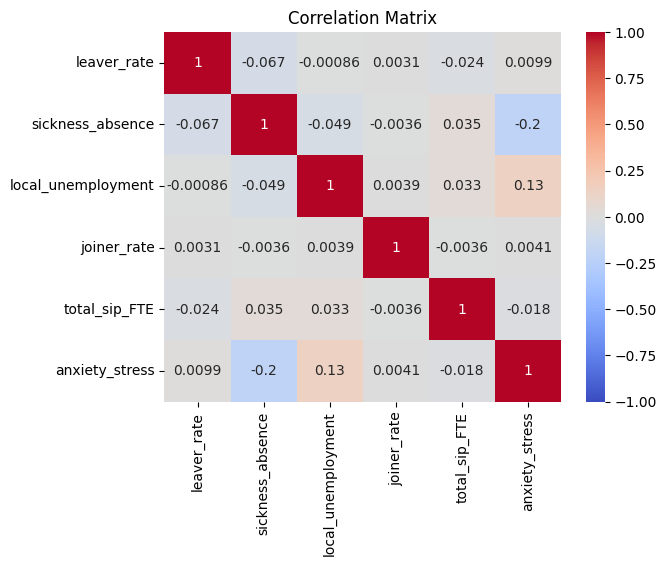

In [194]:
corr_cols = ['leaver_rate', 'sickness_absence',
                                   'local_unemployment','joiner_rate','total_sip_FTE','anxiety_stress']
correlation_matrix = df_leaver_r3[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Create a staff group level dataframe - specify which staff group you want from list below in variable staff_group

In [195]:
sorted(df_leaver_r3['staff_group'].unique())

['All staff groups',
 'Ambulance staff',
 'Central functions',
 'HCHS doctors (exc. junior Drs)',
 'Hotel, property & estates',
 'Managers',
 'Midwives',
 'Nurses & health visitors',
 'Other staff or those with unknown classification',
 'Scientific, therapeutic & technical staff',
 'Senior managers',
 'Support to ST&T staff',
 'Support to ambulance staff',
 'Support to doctors, nurses & midwives']

In [196]:
staff_group = 'Nurses & health visitors'
df_sg = df_leaver_r3[df_leaver_r3['staff_group'] == staff_group].copy()

#df_sg['sickness_absence_rate'] = df_sg['FTE days lost']/df_sg['FTE days available']
#df_sg['leaver_rate'] = df_sg['leave_FTE']/df_sg['denom_FTE']

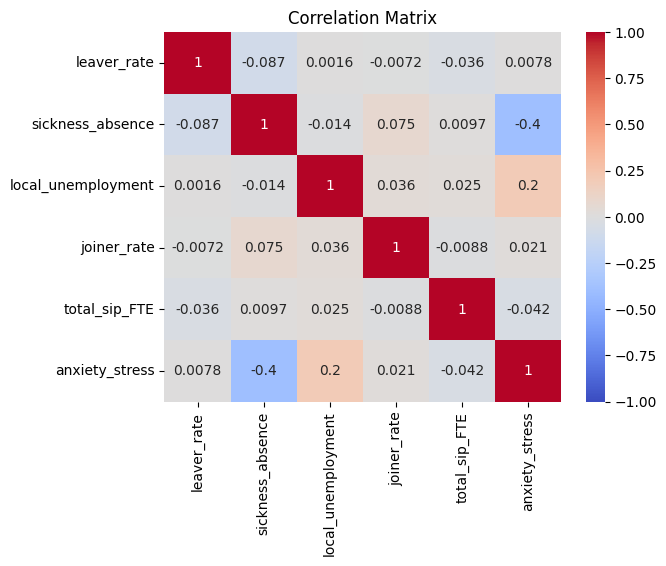

In [197]:
correlation_matrix = df_sg[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

(Optional) Create dummy variables for categorical independent variables

In [141]:
#ivs_cat = ['region_name','staff_group']
#df_with_dummies = pd.get_dummies(df_m, columns=ivs_cat, drop_first=True)
#df_with_dummies.head()

In [198]:
df_leaver_r3.to_csv(f'modelling_data_to_check.csv', index=False)

In [199]:
df_sg.to_csv(f'sg_modelling_data_to_check.csv', index=False)


Specify the dependent variable (dv) and independent variables (ivs). All other fields to be dropped. 

In [205]:
dv = 'leaver_rate'
#ivs = ['local_unemployment','sickness_absence_rate','joiner_rate','sip_FTE']
to_drop = ['month_year','org_code','region_name','org_type','staff_group','joiner_rate',
           'local_unemployment','join_FTE','leave_FTE','denom_FTE','fte_days_lost', dv]

Define the design matrix (X) and the dependent variable (y)


In [206]:
df_leaver_r3.reset_index(drop = True)
X = df_sg.drop(to_drop, axis=1)
y = df_sg[dv]

#y = y.dropna()

y.head()


12    0.015831
13    0.015831
26    0.000000
76    0.012377
77    0.012377
Name: leaver_rate, dtype: float64

In [207]:

# Add a constant column to the design matrix
X = sm.add_constant(X)

X.tail()

# Convert True/False categories to integer 0/1
#bool_columns = X.select_dtypes(include='bool').columns
#X[bool_columns] = X[bool_columns].astype(int)


,const,total_sip_FTE,sickness_absence,anxiety_stress,back_problems,gastro,gynaecological,headache_mig,infectious_dis,other,other_msk,pregnancy_related,respiratory,unknown,month,year
187236,1.0,14708.28982,0.051755,0.306213,0.046656,0.090479,0.045689,0.030042,0.073173,0.081025,0.102775,0.065145,0.076815,0.032989,2,2023
187244,1.0,9236.53334,0.049130,0.306213,0.046656,0.090479,0.045689,0.030042,0.073173,0.081025,0.102775,0.065145,0.076815,0.032989,2,2023
187248,1.0,11575.53280,0.042407,0.306213,0.046656,0.090479,0.045689,0.030042,0.073173,0.081025,0.102775,0.065145,0.076815,0.032989,2,2023
187261,1.0,9236.53334,0.049130,0.306213,0.046656,0.090479,0.045689,0.030042,0.073173,0.081025,0.102775,0.065145,0.076815,0.032989,2,2023
187289,1.0,16471.71801,0.054622,0.306213,0.046656,0.090479,0.045689,0.030042,0.073173,0.081025,0.102775,0.065145,0.076815,0.032989,2,2023


In [208]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            leaver_rate   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     14.22
Date:                Tue, 25 Jul 2023   Prob (F-statistic):           7.44e-37
Time:                        17:00:50   Log-Likelihood:                 31726.
No. Observations:               16248   AIC:                        -6.342e+04
Df Residuals:                   16232   BIC:                        -6.330e+04
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 6.8176      3.19

In [149]:

# Get the summary of the regression results
summary = results.summary()

# # Convert the summary table to a pandas DataFrame
# summary_df = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Format the coefficients and p-values
# summary_df['coef'] = summary_df['coef'].map('{:.4f}'.format)
# summary_df['P>|t|'] = summary_df['P>|t|'].map('{:.4f}'.format)

# Print the formatted summary table
print(summary.tables[1])

                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  8.9151      3.684      2.420      0.016       1.694      16.136
total_sip_FTE        -4.1e-07   8.61e-08     -4.759      0.000   -5.79e-07   -2.41e-07
local_unemployment     0.0480      0.035      1.375      0.169      -0.020       0.116
sickness_absence      -0.1989      0.016    -12.147      0.000      -0.231      -0.167
asthma                -2.5890      0.600     -4.318      0.000      -3.764      -1.414
back_problems          0.2217      0.260      0.852      0.394      -0.288       0.731
blood_disorder         1.1731      1.009      1.163      0.245      -0.804       3.150
dental                -1.6502      1.102     -1.498      0.134      -3.809       0.509
endocrine             -1.4812      0.929     -1.594      0.111      -3.303       0.340
eye                    1.0584      0.880   

This model uses region and type of provider to try and predict NHS staff leaver FTE. The R squared is 0.054, meaning the factors in the model only explain 5.4% of the variation in the data. A lower adjusted R squared than R squared would tell us that some of the model's factors are not contibuting - this is not the case here. 
All variables contribute significantly except being in the Midlands region, NE and Yorkshire, North West or South West.  
The strongest predictors are CCG